In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

dataset from https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#

Data Source:
http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [4]:
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [5]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


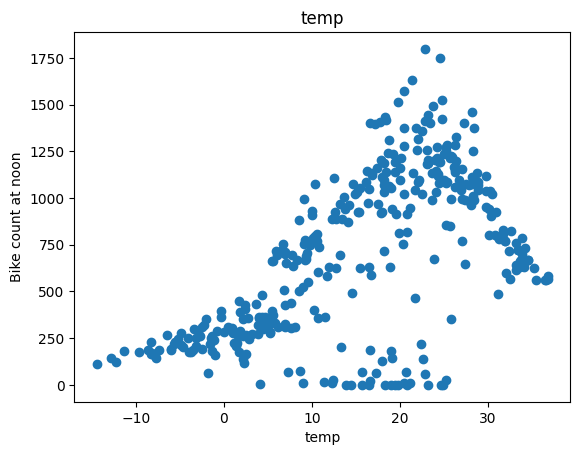

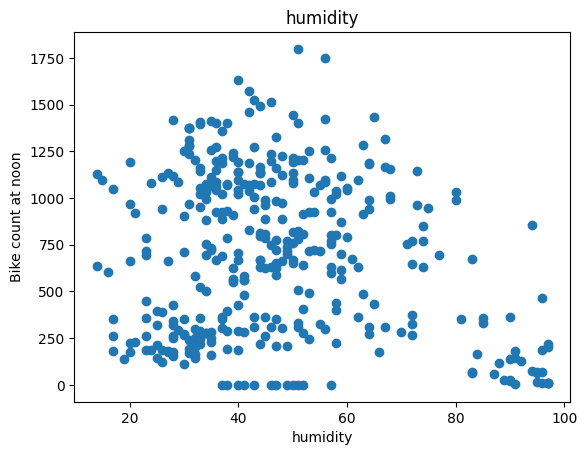

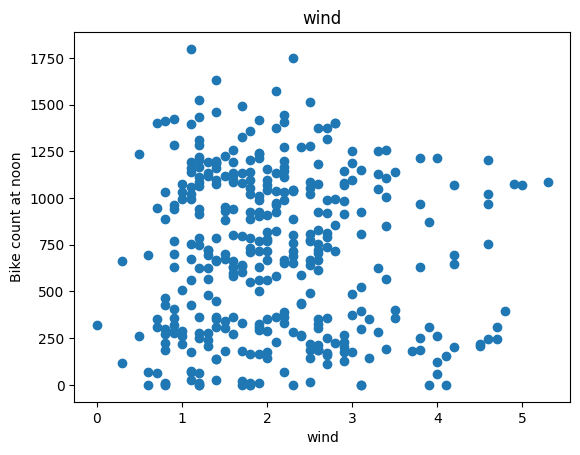

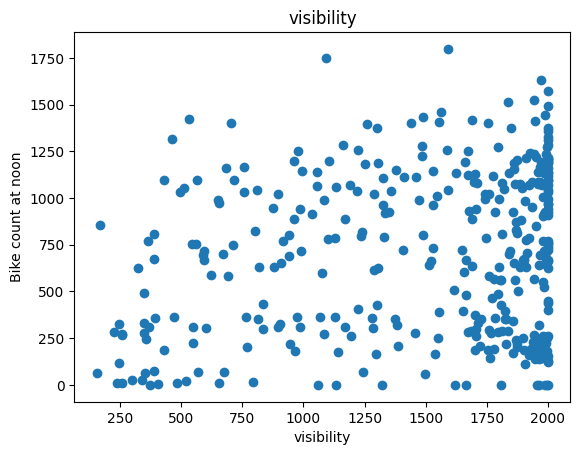

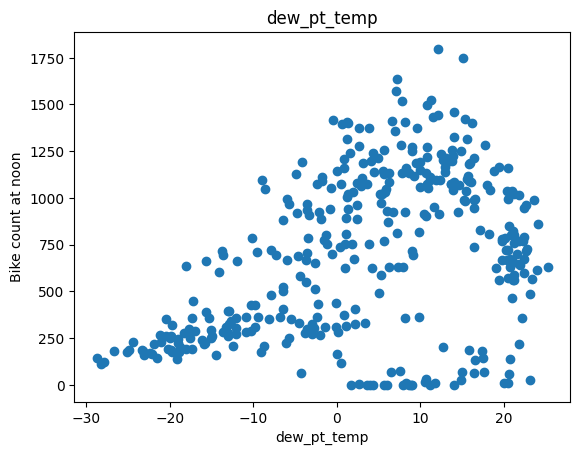

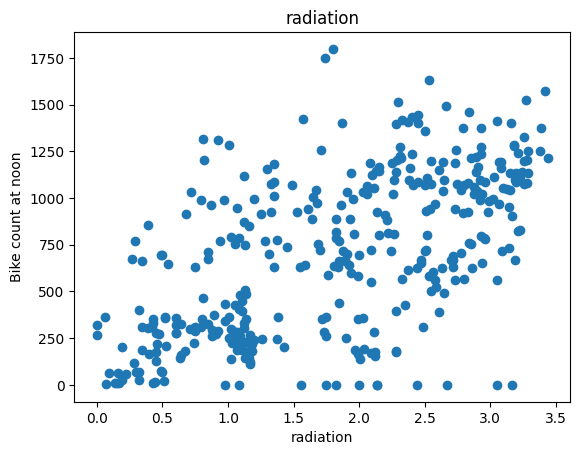

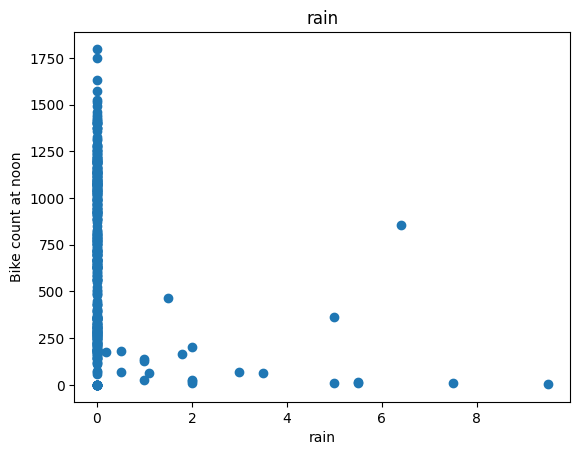

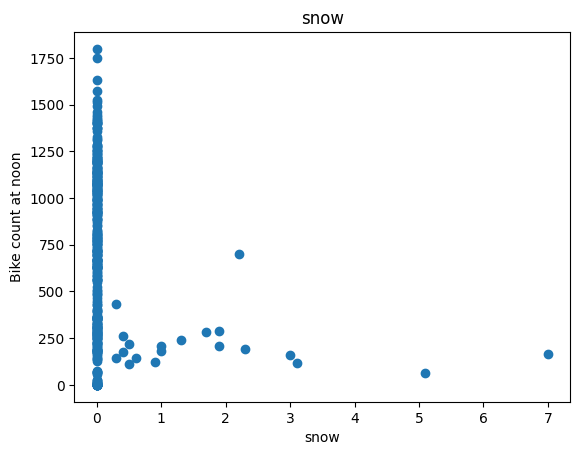

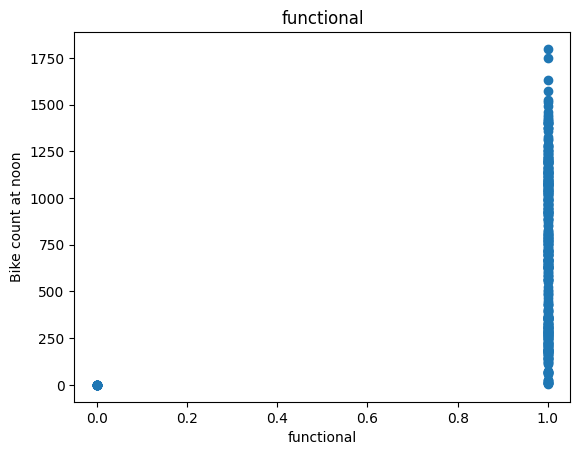

In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel('Bike count at noon')
  plt.xlabel(label)
  plt.show()

In [6]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# train/valid/test dataset

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [9]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [14]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
print(temp_reg.coef_, temp_reg.intercept_)

[[21.62364454]] [336.5868576]


In [ ]:
temp_reg.score(X_test_temp, y_test_temp)

0.31390909189727667

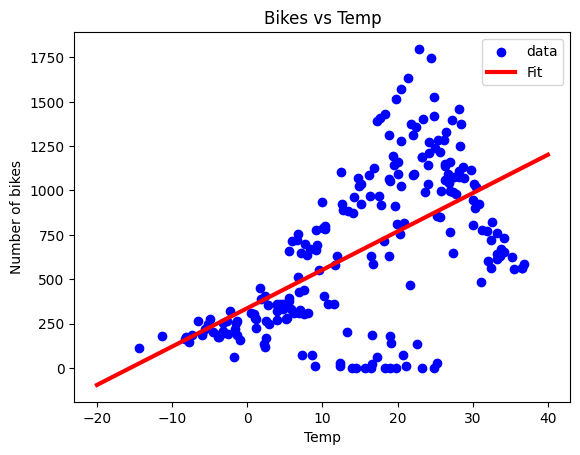

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

#Multiple Linear Regression

In [10]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [11]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [12]:
all_reg.score(X_test_all, y_test_all)

0.48896115029462184

#Regression using Neural Net

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [15]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [16]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [18]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

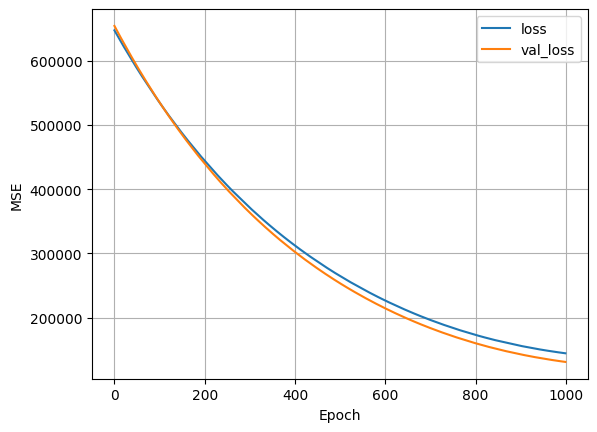

In [21]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


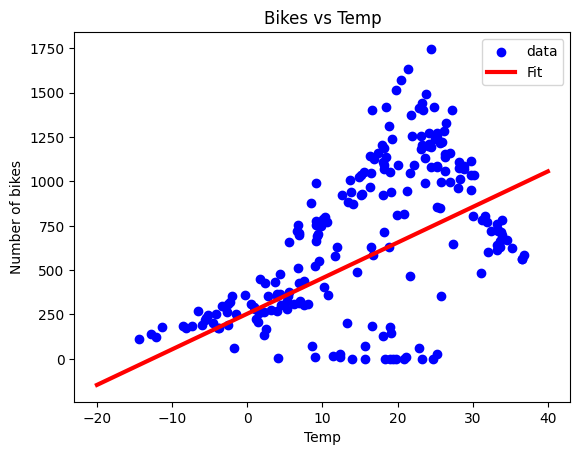

In [22]:
plt.scatter(X_train_temp, y_train_temp, label='data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()